In [110]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt

In [111]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [112]:
#The neural network with one input layer and one output layer,
#but with number of hidden layers specified by the user.
def deep_neural_network(deep_params,x):
    #N_hidden is the number of hidden layers
    N_hidden = len(deep_params) - 1 #-1 since params consists of parameters
    #to all the hidden layers and the output layer.
    
    #Assume input x is being and one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1,num_values)
    
    #Assume the input layer does nothing to the input x
    x_input = x
    # Due to multiple hidden layers, define a variable referencing to the
    # output of the previous layer:
    x_prev = x_input
    
    ##Hidden Layers:
    for l in range(N_hidden):
        w_hidden = deep_params[l]
        
        #Add a row of ones to include bias
        x_prev = np.concatenate((np.ones((1,num_values)),x_prev),axis = 0)
        
        z_hidden = np.matmul(w_hidden,x_prev)
        x_hidden = sigmoid(z_hidden)
        
        #update x_prev such that next layer can use the output from this layer
        x_prev = x_hidden
    #Output Layer:
    
    #Get the weights and bias for this layer
    w_output = deep_params[-1]
    
    #Include bias:
    x_prev = np.concatenate((np.ones((1,num_values)),x_prev),axis = 0)
    
    z_output = np.matmul(w_output,x_prev)
    x_output = z_output
    
    return x_output

In [113]:
#The trial solution using the deep neural network:
def g_trial_deep(x,params,g0=10):
    return g0 + x*deep_neural_network(params,x)

In [114]:
#the right side of ODE
def g(x,g_trial,gamma=2):
    return -gamma*g_trial

In [115]:
def cost_function_deep(P,x):
    #Evaluate the trial function with the current parameters P
    g_t = g_trial_deep(x,P)
    
    #Find the derivative w.r.t x of the neural network
    #here one represents that we need to differentiate deep_n_n fucntion w.r.t x
    #d_net_out = elemtwise_grad(deep_neural_network,1)(P,x)
    
    #Find the derivative w.r.t x of the trial function
    d_g_t = elementwise_grad(g_trial_deep,0)(x,P)
    
    #The right side of ODE
    func = g(x,g_t)
    
    err_sqrt = (d_g_t - func)**2
    cost_sum = np.sum(err_sqrt)
    
    return cost_sum/np.size(err_sqrt)

In [116]:
def solve_ode_deep_neural_network(x,num_neurons,num_itr,lmb):
    #num_neurons is now a list of number of neurons within each hidden layer
    
    #The number of elements in the list num_hidden_neurons thus represents 
    # the number of hidden layers.
    
    #find the number of hidden layers:
    N_hidden = np.size(num_neurons)
    
    #set up initial weights and biases
    
    #initialize the list of parameters:
    P = [None]*(N_hidden+1) #+1 to include the output layer
    #generate num_neurons rows nd 2 cols with random values generated
    P[0] = npr.randn(num_neurons[0],2)
    for l in range(1,N_hidden):
        P[l] = npr.randn(num_neurons[l],num_neurons[l-1]+1) #+1 to include bias
    
    #for the output layer
    P[-1] = npr.randn(1,num_neurons[-1]+1) #+1 to include bias
    
    print('Initial cost: %g'%cost_function_deep(P,x))
    
    #Start finding the optimal weights using gradient descent
    #Find the python fucntion that represents the gradient of the cost function
    #w.r.t the 0-th input argument-- that is weights and biases in the hidden nd output
    cost_function_deep_grad = grad(cost_function_deep,0)
    
    #Let the update be done in num_iter times
    for i in range(num_itr):
        #Evaluate the gradient at the current weights and biases in P.
        #The cost_grad consists of N_hidden + arrayas; the gradient w.r.t 
        #the weights in the hidden and output layers evaluated at x.
        cost_deep_grad = cost_function_deep_grad(P,x)
        
        for l in range(N_hidden+1):
            P[l] = P[l] - lmb*cost_deep_grad[l]
    print('Final Cost: %g'%cost_function_deep(P,x))
    return P

In [117]:
def g_analytic(x, gamma = 2, g0 = 10):
    return g0*np.exp(-gamma*x)

Initial cost: 324.788
Final Cost: 0.140851


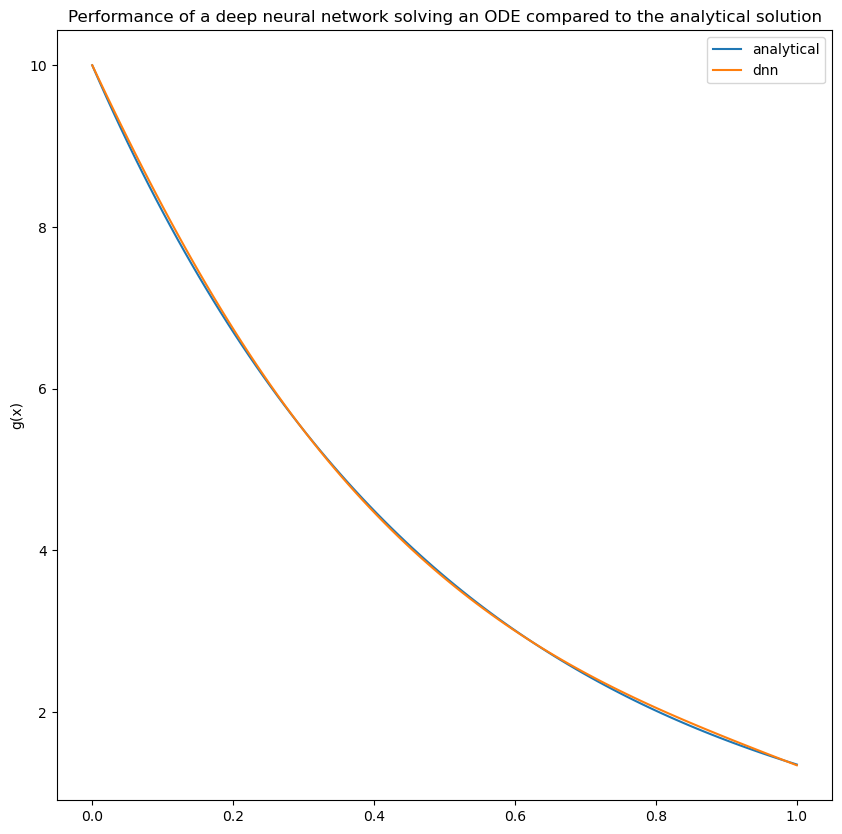

In [118]:
#solve the given problem
if __name__ == '__main__':
    npr.seed(15)
    
    #Decide the values of arguments to the fucntion to solve
    N = 100
    x = np.linspace(0,1,N)
    
    #Set Up the intial parameters
    num_hidden_neurons = np.array([10,10])
    num_itr = 10000
    lmb = 0.001
    
    P = solve_ode_deep_neural_network(x,num_hidden_neurons,num_itr,lmb)
    res = g_trial_deep(x,P)
    res_analytical = g_analytic(x)

    plt.figure(figsize=(10,10))

    plt.title('Performance of a deep neural network solving an ODE compared to the analytical solution')
    plt.plot(x, res_analytical)
    plt.plot(x, res[0,:])
    plt.legend(['analytical','dnn'])
    plt.ylabel('g(x)')
    plt.show()